## Notebook to divide the shelf up into n X n roughly equal boxes. This is a work in progress and I'm figuring out how to automate it. For now - brute force will do, with the starting point being 4 roughly equal boxes. 

In [3]:
import numpy as np
import xgcm
from xgcm import Grid
from xhistogram.xarray import histogram
import xarray as xr
import xroms
from scipy import signal
import glob
import functions #the .py file that contains all the relevant functions
from datetime import datetime

import warnings
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import ticker
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({'font.size': 12})

from dask.distributed import Client

client = Client()

In [4]:
paths = glob.glob('../../../dylan.schlichting/TXLA_Outputs/parent/2010/ocean_his_00*.nc')

ds = xroms.open_mfnetcdf(paths, 
                         chunks = {'ocean_time':1})
ds, grid1 = xroms.roms_dataset(ds, 
                              Vtransform = None)

xislice=slice(260,380) 
etaslice=slice(47,148)

### 

### Start with a picture of the Arawaka C-grid. When we subset the grid - we want the u and v points to be at n-1 with respect to the rho points. In other words, when plotting the control volume, the u and v points on the left boundary should be xi-1 and eta-1 on the LHS and RHS of the control volume.

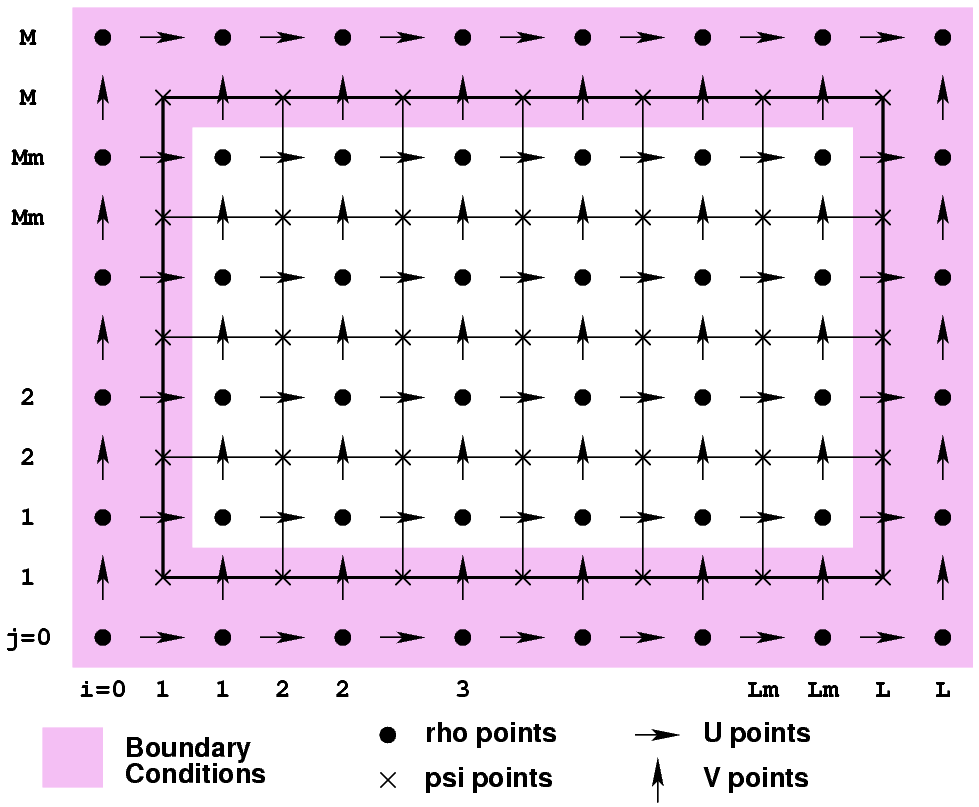

In [ ]:
def box_subset(xislice, etaslice, nx, ny):
    dx = int(np.ceil((xislice.stop-xislice.start)/nx))
    dy = int(np.ceil((etaslice.stop-etaslice.start)/ny))

    xislices = [slice(xislice.start, xislice.stop-dx), 
                slice(xislice.stop-dx-1, xislice.stop)]
    etaslices = [slice(etaslice.start, etaslice.stop-dy), 
                slice(etaslice.stop-dy-1, etaslice.stop)]

    coords = {
            "X": {"center": "xi_rho", "left": "xi_u"},
            "Y": {"center": "eta_rho", "left": "eta_v"},
            "Z": {"center": "s_rho", "outer": "s_w"},
        }

    dssubset = []
    for x in range(len(xislices)):
        for y in range(len(etaslices)):
            dssubset.append(ds.isel(xi_rho = xislices[x], xi_u = slice(xislices[x].start-1, xislices[x].stop-1),
                                    eta_rho = etaslices[y], eta_v = slice(etaslices[y].start-1, etaslices[y].stop-1)))
    grid = []
    for i in range(len(dssubset)):    
        grid.append(xgcm.Grid(dssubset[i], coords=coords, periodic=[]))
        
    return dssubset, grid

In [14]:
nx = 2
ny = 2
dssubset, grid = box_subset(xislice, etaslice, nx, ny)

distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


In [5]:
for i in range(len(dssubset)):
    print('xislices:', [dssubset[i].xi_rho[0].values,dssubset[i].xi_rho[-1].values])

xislices: [array(260), array(319)]
xislices: [array(260), array(319)]
xislices: [array(319), array(379)]
xislices: [array(319), array(379)]


In [11]:
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])
states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')

/scratch/user/dylan.schlichting/.conda/envs/romsenv/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/scratch/user/dylan.schlichting/.conda/envs/romsenv/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: The following kwargs were not used by contour: 'inline'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


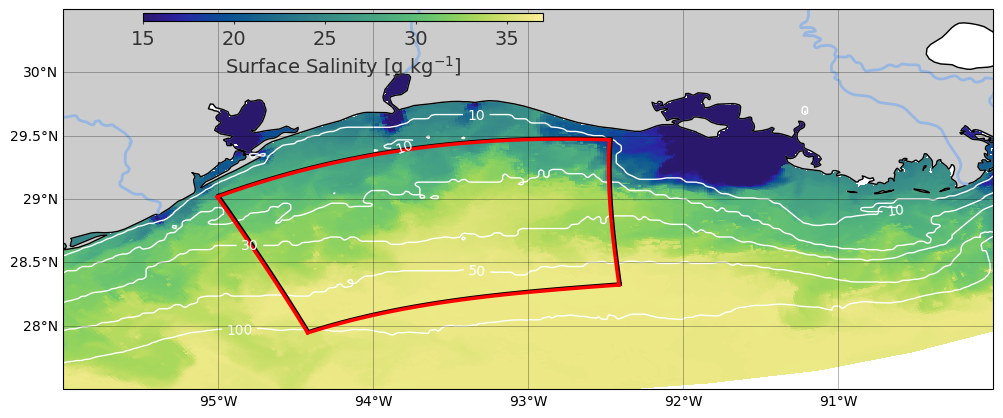

In [12]:
plt.rcParams.update({'font.size': 10})

fig = plt.figure(figsize=(10,4), dpi = 100)
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=ccrs.PlateCarree(central_longitude=-85.0))

hlevs = [10, 20, 30, 50, 100]  # isobath contour depths

mappable = ax.pcolormesh(ds.lon_rho, ds.lat_rho, ds.salt[0,-1], 
                         cmap = cmo.haline, 
                         transform = cartopy.crs.PlateCarree(),
                         vmin = 15, vmax = 37)

gl = ax.gridlines(linewidth=0.4, color='black', alpha=0.5, linestyle='-', draw_labels=True)
ax.set_extent([-96, -90, 27.5, 30.5], ccrs.PlateCarree())
# ax.set_extent([-92.5, -92.3, 29.4, 29.6], ccrs.PlateCarree())
# ax.set_extent([-95, -94, 28, 29.6], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  
ax.add_feature(states_provinces, )
ax.add_feature(cfeature.BORDERS, linestyle='-', )
ax.add_feature(cartopy.feature.RIVERS, linewidth = 2)
ax.set_aspect('auto')

cax = fig.add_axes([0.14, 0.93, 0.4, 0.02]) 
cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label(r'Surface Salinity [g kg$^{-1}$]', fontsize=14, color='0.2')
cb.ax.tick_params(labelsize=14, length=2, color='0.2', labelcolor='0.2')

#Plot isobaths and label the contours
CS = ax.contour(ds.lon_rho, ds.lat_rho, ds.h, hlevs, 
                colors='1', transform=ccrs.PlateCarree(), 
                inline = 1, linewidths=1)
ax.clabel(CS, fmt = '%1.0f', fontsize = 10)
ax.tick_params(axis='y', labelsize=12)

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False

dslonrho = ds.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice)
dslatrho = ds.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice)

dslonu = grid1.interp(ds.lon_u, 'Y', boundary = 'extrapolate').isel(eta_v = slice(etaslice.start-1, etaslice.stop-1), xi_u = slice(xislice.start-1, xislice.stop-1))
dslatv = grid1.interp(ds.lat_v, 'X', boundary = 'extrapolate').isel(eta_v = slice(etaslice.start-1, etaslice.stop-1), xi_u = slice(xislice.start-1, xislice.stop-1))

ax.plot(dslonrho[0,:], dslatrho[0,:], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(dslonrho[:,0], dslatrho[:,0], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(dslonrho[:,-1], dslatrho[:,-1], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(dslonrho[-1,:], dslatrho[-1,:], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)

ax.plot(dslonu[0,:], dslatv[0,:], 'r', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(dslonu[:,0], dslatv[:,0], 'r', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(dslonu[:,-1], dslatv[:,-1], 'r', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(dslonu[-1,:], dslatv[-1,:], 'r', lw=2.5,transform = cartopy.crs.PlateCarree(),)

/scratch/user/dylan.schlichting/.conda/envs/romsenv/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/scratch/user/dylan.schlichting/.conda/envs/romsenv/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: The following kwargs were not used by contour: 'inline'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


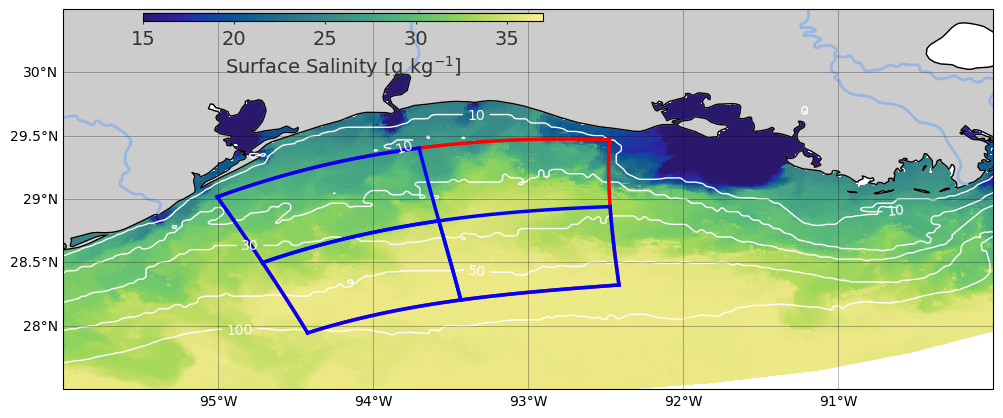

In [11]:
fig = plt.figure(figsize=(10,4), dpi = 100)
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=ccrs.PlateCarree(central_longitude=-85.0))


mappable = ax.pcolormesh(ds.lon_rho, ds.lat_rho, ds.salt[0,-1], 
                         cmap = cmo.haline, 
                         transform = cartopy.crs.PlateCarree(),
                         vmin = 15, vmax = 37)

gl = ax.gridlines(linewidth=0.4, color='black', alpha=0.5, linestyle='-', draw_labels=True)
ax.set_extent([-96, -90, 27.5, 30.5], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  
ax.add_feature(states_provinces, )
ax.add_feature(cfeature.BORDERS, linestyle='-', )
ax.add_feature(cartopy.feature.RIVERS, linewidth = 2)
ax.set_aspect('auto')

cax = fig.add_axes([0.14, 0.93, 0.4, 0.02]) 
cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label(r'Surface Salinity [g kg$^{-1}$]', fontsize=14, color='0.2')
cb.ax.tick_params(labelsize=14, length=2, color='0.2', labelcolor='0.2')

#Plot isobaths and label the contours
CS = ax.contour(ds.lon_rho, ds.lat_rho, ds.h, hlevs, 
                colors='1', transform=ccrs.PlateCarree(), 
                inline = 1, linewidths=1)
ax.clabel(CS, fmt = '%1.0f', fontsize = 10)
ax.tick_params(axis='y', labelsize=12)

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False

dslonrho = ds.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice)
dslatrho = ds.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice)

dslonu = grid1.interp(ds.lon_u, 'Y', boundary = 'extrapolate').isel(eta_v = slice(etaslice.start-1, etaslice.stop-1), xi_u = slice(xislice.start-1, xislice.stop-1))
dslatv = grid1.interp(ds.lat_v, 'X', boundary = 'extrapolate').isel(eta_v = slice(etaslice.start-1, etaslice.stop-1), xi_u = slice(xislice.start-1, xislice.stop-1))

ax.plot(dslonu[0,:], dslatv[0,:], 'r', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(dslonu[:,0], dslatv[:,0], 'r', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(dslonu[:,-1], dslatv[:,-1], 'r', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(dslonu[-1,:], dslatv[-1,:], 'r', lw=2.5,transform = cartopy.crs.PlateCarree(),)

for i in range(4):
    dsslonu = grid[i].interp(dssubset[i].lon_rho, 'Y', boundary = 'extrapolate')
    dsslatv = grid[i].interp(dssubset[i].lat_rho, 'X', boundary = 'extrapolate')
    
    dsslonuv = grid[i].interp(dsslonu, 'X', boundary = 'extrapolate')
    dsslatvu = grid[i].interp(dsslatv, 'Y', boundary = 'extrapolate')
    
    ax.plot(dsslonuv[0,:], dsslatvu[0,:], 'b', lw=2.5,transform = cartopy.crs.PlateCarree(),)
    ax.plot(dsslonuv[:,0], dsslatvu[:,0], 'b', lw=2.5,transform = cartopy.crs.PlateCarree(),)
    ax.plot(dsslonuv[:,-1], dsslatvu[:,-1], 'b', lw=2.5,transform = cartopy.crs.PlateCarree(),)
    ax.plot(dsslonuv[-1,:], dsslatvu[-1,:], 'b', lw=2.5,transform = cartopy.crs.PlateCarree(),)

#### Open netcdf output from driver scripts, combine them based on box number, then clean the subsetted directory. 

In [16]:
Qsvarhds = []
Qshds = []
Qhds = []
for i in range(4):
    Qsvarhds.append(xr.open_mfdataset('/scratch/user/dylan.schlichting/tef/largecv/box_subset/Qsvar/Qsvarh_hourly_2010_highres_box_'+str(i)+'_day_*.nc'))
    Qshds.append(xr.open_mfdataset('/scratch/user/dylan.schlichting/tef/largecv/box_subset/Qs/Qsh_hourly_2010_highres_box_'+str(i)+'_day_*.nc'))
    Qhds.append(xr.open_mfdataset('/scratch/user/dylan.schlichting/tef/largecv/box_subset/Q/Qh_hourly_2010_highres_box_'+str(i)+'_day_*.nc'))


In [17]:
ds1 = []
for i in range(4):
    ds1.append(xr.merge([Qsvarhds[i], Qshds[i], Qhds[i]]))

In [18]:
def exchange_flow(ds):
    '''
Computes the total exchange flow parameters define by MacCready (2011) JPO and MacCready et al. (2018).
Requires a dataset containing tracer transport weighted histograms of volume, salt, and salt variance.
Currently based on the sign method. 
    '''
    #Volume Flux - need to apply divergence here. Sign convention is EN+
    #so the net tracer flux is W - E + S - N; Drawing a picture helps too. 
    Qnet = (ds.QWh-ds.QEh+ds.QSh-ds.QNh)
    Qnet.name = 'Qnet'
    Qout = (Qnet.where(Qnet<0).sum('salt_bin'))
    Qout.name = 'Qout'
    Qin = (Qnet.where(Qnet>0).sum('salt_bin'))
    Qin.name = 'Qin'

    #Salt Flux
    Qsnet = (ds.QsWh-ds.QsEh+ds.QsSh-ds.QsNh)
    Qsnet.name = 'Qsnet'
    Qsout = (Qsnet.where(Qsnet<0).sum('salt_bin'))
    Qsout.name = 'Qsout'
    Qsin = (Qsnet.where(Qsnet>0).sum('salt_bin'))
    Qsin.name = 'Qsin'

    #Inflowing and outflowing salinities: salt flux divided by volume flux = salt 
    sin = (Qsin/Qin)
    sin.name = 'sin'
    sout = (Qsout/Qout)
    sout.name = 'sout'

    #Calculate the different tracer advections.
    voladv = (Qin+Qout)
    voladv.name = 'voladv'
    #Need to fill NaNs because the flow can be unidirectional causing division by zero.
    saltadv = (Qin*sin).fillna(0)+(Qout*sout).fillna(0) 
    saltadv.name = 'saltadv'

    #Salinity variance
    Qsvarnet = (ds.QsvarWh-ds.QsvarEh+ds.QsvarSh-ds.QsvarNh)
    Qsvarnet.name = 'Qsvarnet'

    Qsvarout = (Qsvarnet.where(Qsvarnet<0).sum('salt_bin'))
    Qsvarout.name = 'Qsvarout'
    Qsvarin = (Qsvarnet.where(Qsvarnet>0).sum('salt_bin'))
    Qsvarin.name = 'Qsvarin'

    svarin = (Qsvarin/Qin)
    svarin.name = 'svarin'
    svarout = (Qsvarout/Qout)
    svarout.name = 'svarout'

    svaradv = ((Qin*svarin).fillna(0)+(Qout*svarout).fillna(0))
    svaradv.name = 'svaradv'

    ds = xr.merge([Qnet, Qin, Qout, Qsnet, Qsin, Qsout, 
                   Qsvarnet, Qsvarin, Qsvarout, sin, sout, svarin,
                   svarout, voladv, saltadv, svaradv], compat = 'override')

    return ds

In [19]:
dse = []
for i in range(4):
    dse.append(exchange_flow(ds1[i]))

In [21]:
for i in range(4):
    path = '/scratch/user/dylan.schlichting/tef/largecv/budgets/tef_hourly_2010_st300_highres_box_'+str(i)+'*.nc'
    dse[i].to_netcdf(path)

distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


In [13]:
# chidvboxes = []
# for i in range(4):
#     path = '/scratch/user/dylan.schlichting/tef/largecv/box_subset/chiint/chiint__notdV_hourly_2010_highres_box_'+str(i)+'*'
#     chidvboxes.append(xr.open_mfdataset(path))

In [14]:
# for i in range(4):
#      path = '/scratch/user/dylan.schlichting/tef/largecv/budgets/chiint_notdV_hourly_2010_highres_box_'+str(i)+'.nc'
#      chidvboxes[i].to_netcdf(path, mode = 'w')

In [20]:
# vboxes = []
# for i in range(4):
#     vboxes.append(xr.open_mfdataset('/scratch/user/dylan.schlichting/tef/largecv/entrainment/V/Vh_hourly_2010_highres_box_'+str(i)+'*.nc'))

In [21]:
for i in range(4):
    path = '/scratch/user/dylan.schlichting/tef/largecv/budgets/Vh_hourly_2010_highres_box_'+str(i)+'*.nc'
    vboxes[i].to_netcdf(path)

### Open TEF, salt variance dissipation, and box volume in TS space subsetted for the smaller control volumes. SW, NW, SE, NE.

In [3]:
tefboxes = []
chidvboxes = []
chiboxes = []
vboxes = []
for i in range(4):
    tefboxes.append(xr.open_dataset('/scratch/user/dylan.schlichting/tef/largecv/budgets/tef_hourly_2010_highres_box_'+str(i)+'.nc')) 
    vboxes.append(xr.open_dataset('/scratch/user/dylan.schlichting/tef/largecv/budgets/Vh_hourly_2010_highres_box_'+str(i)+'*.nc'))
    chiboxes.append(xr.open_dataset('/scratch/user/dylan.schlichting/tef/largecv/budgets/chiint_hourly_2010_highres_box_'+str(i)+'.nc').chi)
    chidvboxes.append(xr.open_dataset('/scratch/user/dylan.schlichting/tef/largecv/budgets/chiint_notdV_hourly_2010_highres_box_'+str(i)+'.nc').chi) 

### Mixing per unit volume 

In [13]:
chiperv = []
for i in range(4):
    chiperv.append(chidvboxes[i]/vboxes[i].dV_saltcoord)

In [16]:
tempbins = np.linspace(0,40,501)
saltbins = np.linspace(0,40,501)
T,S = np.meshgrid(tempbins, saltbins)
rho = 1027.0*((1+7.6*10**(-4)*(S-35))-(1.7*10**(-4)*(T-25)))-1000

Text(0, 0.5, '')

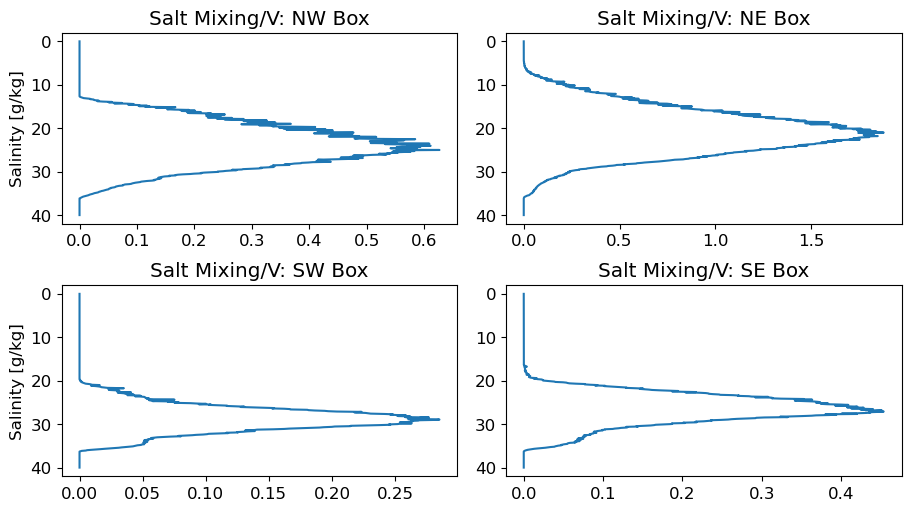

In [20]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(2,2, figsize = (9,5), dpi = 100, constrained_layout = True)

#NW
m0 = chiperv[1].sum(['ocean_time', 'temp_bin']).plot(ax = ax[0,0], y = 'salt_bin')

#SW
m1 = chiperv[0].sum(['ocean_time', 'temp_bin']).plot(ax = ax[1,0], y = 'salt_bin')

# #NE
m2 = chiperv[3].sum(['ocean_time', 'temp_bin']).plot(ax = ax[0,1], y = 'salt_bin')

#SE
m3 = chiperv[2].sum(['ocean_time', 'temp_bin']).plot(ax = ax[1,1], y = 'salt_bin')

ax[0,0].invert_yaxis()
ax[0,1].invert_yaxis()
ax[1,0].invert_yaxis()
ax[1,1].invert_yaxis()

ax[0,0].set_title('Salt Mixing/V: NW Box')
ax[1,0].set_title('Salt Mixing/V: SW Box')
ax[0,1].set_title('Salt Mixing/V: NE Box')
ax[1,1].set_title('Salt Mixing/V: SE Box')

ax[0,0].set_ylabel('Salinity [g/kg]')
ax[1,0].set_ylabel('Salinity [g/kg]')
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')

/scratch/user/dylan.schlichting/.conda/envs/romsenv/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/scratch/user/dylan.schlichting/.conda/envs/romsenv/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/scratch/user/dylan.schlichting/.conda/envs/romsenv/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/scratch/user/dylan.schlichting/.conda/envs/romsenv/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


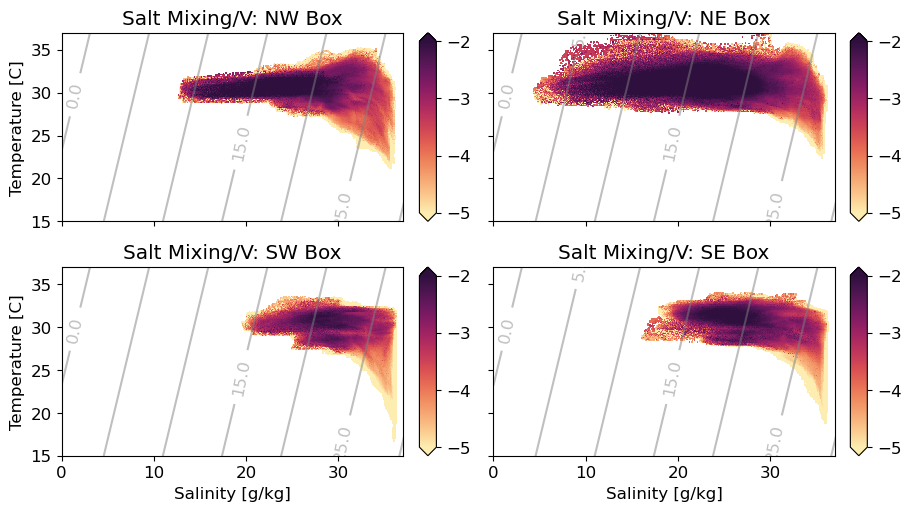

In [18]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(2,2, figsize = (9,5), dpi = 100, constrained_layout = True)

#NW
m0 = np.log10(chiperv[1].sum('ocean_time')).plot(ax = ax[0,0],
                                   y = 'temp_bin', 
                                   cmap = cmo.matter,
                                   vmin = -5, vmax = -2,
                                   cbar_kwargs = {'label': ''})

#SW
m1 = np.log10(chiperv[0].sum('ocean_time')).plot(ax = ax[1,0],
                                   y = 'temp_bin', 
                                   cmap = cmo.matter,
                                   vmin = -5, vmax = -2,
                                   cbar_kwargs = {'label': ''})

#NE
m2 = np.log10(chiperv[3].sum('ocean_time')).plot(ax = ax[0,1],
                                   y = 'temp_bin', 
                                   cmap = cmo.matter,
                                   vmin = -5, vmax = -2,
                                   cbar_kwargs = {'label': ''})

#SE
m3 = np.log10(chiperv[2].sum('ocean_time')).plot(ax = ax[1,1],
                                   y = 'temp_bin', 
                                   cmap = cmo.matter,
                                   vmin = -5, vmax = -2,
                                   cbar_kwargs = {'label': ''})


ax[0,0].set_xlim(0,37)
ax[0,0].set_ylim(15,37)

ax[1,0].set_xlim(0,37)
ax[1,0].set_ylim(15,37)

ax[0,1].set_xlim(0,37)
ax[0,1].set_ylim(15,37)

ax[1,1].set_xlim(0,37)
ax[1,1].set_ylim(15,37)

ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[0,1].set_xlabel('')
ax[0,0].set_xlabel('')

ax[0,0].set_ylabel('Temperature [C]')
ax[1,0].set_ylabel('Temperature [C]')
ax[1,0].set_xlabel('Salinity [g/kg]')
ax[1,1].set_xlabel('Salinity [g/kg]')

ax[0,1].set_xlabel('')

ax[0,0].set_title('Salt Mixing/V: NW Box')
ax[1,0].set_title('Salt Mixing/V: SW Box')
ax[0,1].set_title('Salt Mixing/V: NE Box')
ax[1,1].set_title('Salt Mixing/V: SE Box')

ax[0,0].axes.xaxis.set_ticklabels([])
ax[0,1].axes.xaxis.set_ticklabels([])

ax[0,1].axes.yaxis.set_ticklabels([])
ax[1,1].axes.yaxis.set_ticklabels([])

cs = ax[0,0].contour(S,T,rho, colors = 'grey', alpha = 0.5)
cl = plt.clabel(cs,fontsize=12,inline=True,fmt='%.1f')
cs = ax[1,0].contour(S,T,rho, colors = 'grey', alpha = 0.5)
cl = plt.clabel(cs,fontsize=12,inline=True,fmt='%.1f')
cs = ax[0,1].contour(S,T,rho, colors = 'grey', alpha = 0.5)
cl = plt.clabel(cs,fontsize=12,inline=True,fmt='%.1f')
cs = ax[1,1].contour(S,T,rho, colors = 'grey', alpha = 0.5)
cl = plt.clabel(cs,fontsize=12,inline=True,fmt='%.1f')

In [9]:
Qnorm0 = (tefboxes[0].Qnet.sum('ocean_time')/(tefboxes[0].Qnet.sum('ocean_time').max()))
Qsnorm0 = (tefboxes[0].Qsnet.sum('ocean_time')/(tefboxes[0].Qsnet.sum('ocean_time').max()))
Qsvarnorm0 = (tefboxes[0].Qsvarnet.sum('ocean_time')/(tefboxes[0].Qsvarnet.sum('ocean_time').max()))

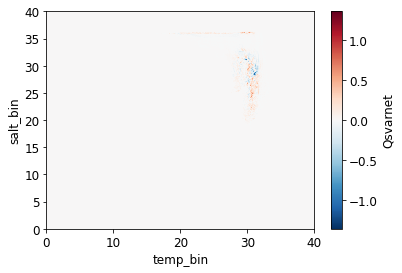

In [12]:
Qsvarnorm0.plot()

In [7]:
Qnorm0 = (tefboxes[0].Qnet.sum('ocean_time')/(tefboxes[0].Qnet.sum('ocean_time').max()))
Qsnorm0 = (tefboxes[0].Qsnet.sum('ocean_time')/(tefboxes[0].Qsnet.sum('ocean_time').max()))
Qsvarnorm0 = (tefboxes[0].Qsvarnet.sum('ocean_time')/(tefboxes[0].Qsvarnet.sum('ocean_time').max()))

In [3]:
Qnorm1 = (tefboxes[1].Qnet.sum('ocean_time')/(tefboxes[1].Qnet.sum('ocean_time').max()))
Qsnorm1 = (tefboxes[1].Qsnet.sum('ocean_time')/(tefboxes[1].Qsnet.sum('ocean_time').max()))
Qsvarnorm1 = (tefboxes[1].Qsvarnet.sum('ocean_time')/(tefboxes[1].Qsvarnet.sum('ocean_time').max()))

In [4]:
Qnorm2 = (tefboxes[2].Qnet.sum('ocean_time')/(tefboxes[2].Qnet.sum('ocean_time').max()))
Qsnorm2 = (tefboxes[2].Qsnet.sum('ocean_time')/(tefboxes[2].Qsnet.sum('ocean_time').max()))
Qsvarnorm2 = (tefboxes[2].Qsvarnet.sum('ocean_time')/(tefboxes[2].Qsvarnet.sum('ocean_time').max()))

In [5]:
Qnorm3 = (tefboxes[3].Qnet.sum('ocean_time')/(tefboxes[3].Qnet.sum('ocean_time').max()))
Qsnorm3 = (tefboxes[3].Qsnet.sum('ocean_time')/(tefboxes[3].Qsnet.sum('ocean_time').max()))
Qsvarnorm3 = (tefboxes[3].Qsvarnet.sum('ocean_time')/(tefboxes[3].Qsvarnet.sum('ocean_time').max()))

In [8]:
Qnorm = [Qnorm0, Qnorm1, Qnorm2, Qnorm3]
Qsnorm = [Qsnorm0, Qsnorm1, Qsnorm2, Qsnorm3]
Qsvarnorm = [Qsvarnorm0, Qsvarnorm1, Qsvarnorm2, Qsvarnorm3]

In [ ]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(4,3, figsize = (11,7), dpi = 100, constrained_layout = True)

for item in range(4):
    m0 = Qnorm[item].plot(y = 'temp_bin', 
               ax = ax[item,0],
               cmap = cmo.balance,
               norm=colors.SymLogNorm(linthresh=0.001, linscale=0.1, vmin=-1.0, vmax=1.0),
               add_colorbar=False,)

    ax[item,0].set_xlim(0,37)
    ax[item,0].set_ylim(15,35)
    ax[item,0].set_ylabel('$\Theta$ [$^{\circ}$ C]')

    m1 = Qsnorm[item].plot(y = 'temp_bin', 
                ax = ax[item,1],
                cmap = cmo.balance,
                norm = colors.SymLogNorm(linthresh=0.001, linscale=0.1, vmin=-1.0, vmax=1.0),
                add_colorbar=False)

    ax[item,1].set_xlim(0,37)
    ax[item,1].set_ylim(15,35)
    ax[item,1].set_ylabel('')
    ax[item,1].axes.yaxis.set_ticklabels([])

    m2 = Qsvarnorm[item].plot(y = 'temp_bin', 
                   ax = ax[item,2],
                   cmap = cmo.balance,
                   norm = colors.SymLogNorm(linthresh=0.001, linscale=0.1, vmin=-1.0, vmax=1.0),
                   add_colorbar=False)

    ax[item,2].set_xlim(0,37)
    ax[item,2].set_ylim(15,35)
    ax[item,2].set_ylabel('')

    ax[item,2].axes.yaxis.set_ticklabels([])

    tick_locations = [-1, -0.01, -0.1, 0, 0.01, 0.1, 1]
    cb = plt.colorbar(m0, ax = ax[item,0], aspect = 20, ticks=tick_locations, format=ticker.LogFormatterMathtext())
    cb.remove()
    cb = plt.colorbar(m1, ax = ax[item,1], aspect = 20, ticks=tick_locations, format=ticker.LogFormatterMathtext())
    cb.remove()
    plt.colorbar(m2, ax = ax[item,2], aspect = 20, ticks=tick_locations, format=ticker.LogFormatterMathtext())


for item in range(3):
    cs = ax[0,item].contour(S,T,rho, colors = 'grey', alpha = 0.5)
    cl = plt.clabel(cs,fontsize=12,inline=True,fmt='%.1f')
    cs = ax[1,item].contour(S,T,rho, colors = 'grey', alpha = 0.5)
    cl = plt.clabel(cs,fontsize=12,inline=True,fmt='%.1f')
    cs = ax[2,item].contour(S,T,rho, colors = 'grey', alpha = 0.5)
    cl = plt.clabel(cs,fontsize=12,inline=True,fmt='%.1f')
    cs = ax[3,item].contour(S,T,rho, colors = 'grey', alpha = 0.5)
    cl = plt.clabel(cs,fontsize=12,inline=True,fmt='%.1f')
    
   
ax[0,0].axes.xaxis.set_ticklabels([])
ax[0,1].axes.xaxis.set_ticklabels([])
ax[0,2].axes.xaxis.set_ticklabels([])
ax[1,0].axes.xaxis.set_ticklabels([])
ax[1,1].axes.xaxis.set_ticklabels([])
ax[1,2].axes.xaxis.set_ticklabels([])
ax[2,0].axes.xaxis.set_ticklabels([])
ax[2,1].axes.xaxis.set_ticklabels([])
ax[2,2].axes.xaxis.set_ticklabels([])

ax[0,0].axes.set_xlabel('')
ax[0,1].axes.set_xlabel('')
ax[0,2].axes.set_xlabel('')
ax[1,0].axes.set_xlabel('')
ax[1,1].axes.set_xlabel('')
ax[1,2].axes.set_xlabel('')
ax[2,1].set_xlabel('')
ax[2,0].set_xlabel('')
ax[2,2].set_xlabel('')

ax[3,1].set_xlabel('Salinity [g/kg]')
ax[3,0].set_xlabel('Salinity [g/kg]')
ax[3,2].set_xlabel('Salinity [g/kg]')

ax[0,0].set_title('Norm. Volume Flux')
ax[0,1].set_title('Norm. Salt Flux')
ax[0,2].set_title('Norm. Salt Variance Flux')

<ipython-input-23-c025f99f3f9e>:8: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm=colors.SymLogNorm(linthresh=0.001, linscale=0.1, vmin=-1.0, vmax=1.0),
<ipython-input-23-c025f99f3f9e>:18: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm = colors.SymLogNorm(linthresh=0.001, linscale=0.1, vmin=-1.0, vmax=1.0),
<ipython-input-23-c025f99f3f9e>:29: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm = colors.SymLogNorm(linthresh=0.001, linscale=0.1, vmin=-1.0, vmax=1.0),
<ipython-input-23-c025f99f3f9e>:47: UserWarning: The following kwargs were not used by contour: 'label'
  cs = ax[0,item].contour(S,T,rho, colors = 'grey', alpha = 0.5, label = 'West')
<ipython-input-23-c025f99f3f9e>:49: UserWarning: T

Text(0.5, 1.0, 'Norm. Salt Variance Flux')

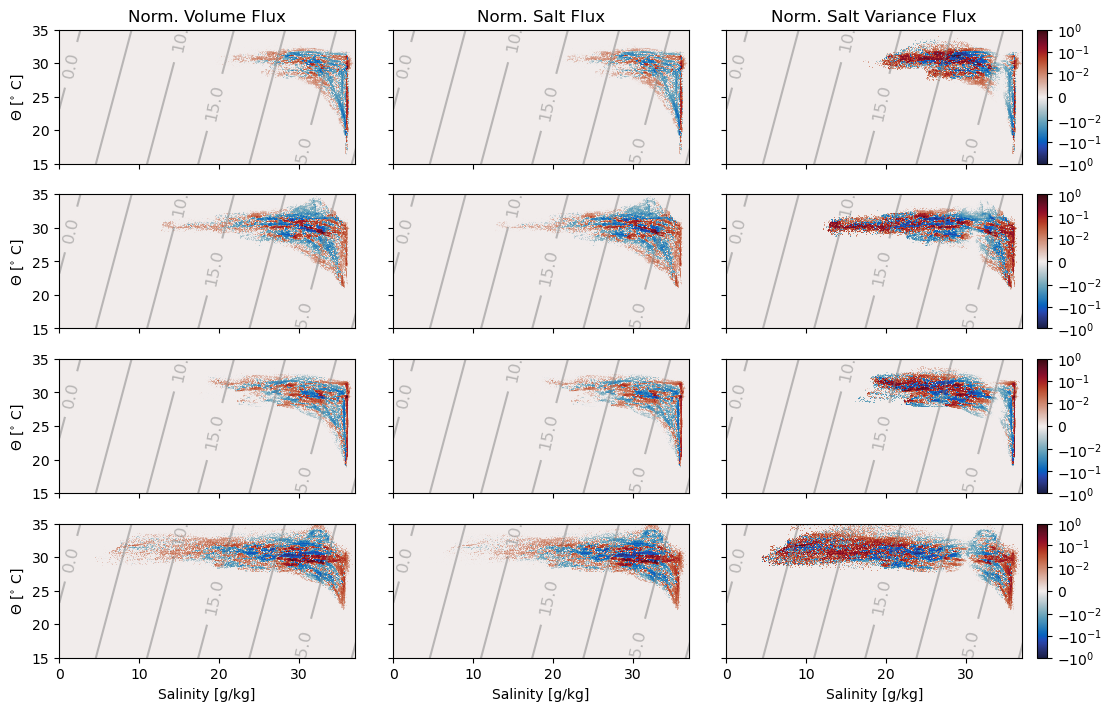

In [23]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(4,3, figsize = (11,7), dpi = 100, constrained_layout = True)

for item in range(4):
    m0 = Qnorm[item].plot(y = 'temp_bin', 
               ax = ax[item,0],
               cmap = cmo.balance,
               norm=colors.SymLogNorm(linthresh=0.001, linscale=0.1, vmin=-1.0, vmax=1.0),
               add_colorbar=False,)

    ax[item,0].set_xlim(0,37)
    ax[item,0].set_ylim(15,35)
    ax[item,0].set_ylabel('$\Theta$ [$^{\circ}$ C]')

    m1 = Qsnorm[item].plot(y = 'temp_bin', 
                ax = ax[item,1],
                cmap = cmo.balance,
                norm = colors.SymLogNorm(linthresh=0.001, linscale=0.1, vmin=-1.0, vmax=1.0),
                add_colorbar=False)

    ax[item,1].set_xlim(0,37)
    ax[item,1].set_ylim(15,35)
    ax[item,1].set_ylabel('')
    ax[item,1].axes.yaxis.set_ticklabels([])

    m2 = Qsvarnorm[item].plot(y = 'temp_bin', 
                   ax = ax[item,2],
                   cmap = cmo.balance,
                   norm = colors.SymLogNorm(linthresh=0.001, linscale=0.1, vmin=-1.0, vmax=1.0),
                   add_colorbar=False)

    ax[item,2].set_xlim(0,37)
    ax[item,2].set_ylim(15,35)
    ax[item,2].set_ylabel('')

    ax[item,2].axes.yaxis.set_ticklabels([])

    tick_locations = [-1, -0.01, -0.1, 0, 0.01, 0.1, 1]
    cb = plt.colorbar(m0, ax = ax[item,0], aspect = 20, ticks=tick_locations, format=ticker.LogFormatterMathtext())
    cb.remove()
    cb = plt.colorbar(m1, ax = ax[item,1], aspect = 20, ticks=tick_locations, format=ticker.LogFormatterMathtext())
    cb.remove()
    plt.colorbar(m2, ax = ax[item,2], aspect = 20, ticks=tick_locations, format=ticker.LogFormatterMathtext())


for item in range(3):
    cs = ax[0,item].contour(S,T,rho, colors = 'grey', alpha = 0.5)
    cl = plt.clabel(cs,fontsize=12,inline=True,fmt='%.1f')
    cs = ax[1,item].contour(S,T,rho, colors = 'grey', alpha = 0.5)
    cl = plt.clabel(cs,fontsize=12,inline=True,fmt='%.1f')
    cs = ax[2,item].contour(S,T,rho, colors = 'grey', alpha = 0.5)
    cl = plt.clabel(cs,fontsize=12,inline=True,fmt='%.1f')
    cs = ax[3,item].contour(S,T,rho, colors = 'grey', alpha = 0.5)
    cl = plt.clabel(cs,fontsize=12,inline=True,fmt='%.1f')
    
   
ax[0,0].axes.xaxis.set_ticklabels([])
ax[0,1].axes.xaxis.set_ticklabels([])
ax[0,2].axes.xaxis.set_ticklabels([])
ax[1,0].axes.xaxis.set_ticklabels([])
ax[1,1].axes.xaxis.set_ticklabels([])
ax[1,2].axes.xaxis.set_ticklabels([])
ax[2,0].axes.xaxis.set_ticklabels([])
ax[2,1].axes.xaxis.set_ticklabels([])
ax[2,2].axes.xaxis.set_ticklabels([])

ax[0,0].axes.set_xlabel('')
ax[0,1].axes.set_xlabel('')
ax[0,2].axes.set_xlabel('')
ax[1,0].axes.set_xlabel('')
ax[1,1].axes.set_xlabel('')
ax[1,2].axes.set_xlabel('')
ax[2,1].set_xlabel('')
ax[2,0].set_xlabel('')
ax[2,2].set_xlabel('')

ax[3,1].set_xlabel('Salinity [g/kg]')
ax[3,0].set_xlabel('Salinity [g/kg]')
ax[3,2].set_xlabel('Salinity [g/kg]')

ax[0,0].set_title('Norm. Volume Flux')
ax[0,1].set_title('Norm. Salt Flux')
ax[0,2].set_title('Norm. Salt Variance Flux')

In [35]:
for i in range(4):
    print('Salinity Variance Flux STD, ' + 'Box: '+str(i)+':', Qsvarnorm[i].std().values)
    
for i in range(4):
    print('Salt Flux STD, ' + 'Box: '+str(i)+':', Qsnorm[i].std().values)
    
for i in range(4):
    print('Vol Flux STD, ' + 'Box: '+str(i)+':', Qnorm[i].std().values)

Salinity Variance Flux STD, Box: 0: 0.022819517376711843
Salinity Variance Flux STD, Box: 1: 0.022585531183529944
Salinity Variance Flux STD, Box: 2: 0.022539794765399506
Salinity Variance Flux STD, Box: 3: 0.022143256148370587
Salt Flux STD, Box: 0: 0.006013758288301088
Salt Flux STD, Box: 1: 0.01111891161336076
Salt Flux STD, Box: 2: 0.0077628395385365674
Salt Flux STD, Box: 3: 0.01865151272510793
Vol Flux STD, Box: 0: 0.006209485853723611
Vol Flux STD, Box: 1: 0.011703936425867341
Vol Flux STD, Box: 2: 0.008183889570952004
Vol Flux STD, Box: 3: 0.017875158398684605
